# **Multi-Asset LSTM Trading Strategies: Single vs. Multi-Output Model Performance**

In [ ]:
# Enable inline plotting (for Jupyter Notebook only)
# Note: Use this only if running in Jupyter Notebook
%matplotlib inline

# Suppress warnings (for cleaner report)
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Financial data and statistical libraries
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine learning and data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# To save processed data and models
import os
import pickle

# Ensure data and model directories exist
os.makedirs("./data/raw", exist_ok=True)
os.makedirs("./data/processed", exist_ok=True)
os.makedirs("./data/models", exist_ok=True)

# Print confirmation of imports
print("All packages are installed and imported successfully!")

2024-12-04 16:17:43.253075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


All packages are installed and imported successfully!


## **Step 1: Data Gathering and Exploration**

### **1. Download and Process ETF Data**

The first step involves fetching the adjusted closing prices of five ETFs representing different asset classes using the `yfinance` library. These ETFs include SPY (Equity), TLT (Long-term Bonds), SHY (Short-term Bonds), GLD (Gold), and DBO (Oil). The data is cleaned and saved for reproducibility.


In [ ]:
# Define ETFs and date range
etfs = ['SPY', 'TLT', 'SHY', 'GLD', 'DBO']
start_date = "2018-01-01"
end_date = "2022-12-30"

# Download Adjusted Close prices
df = yf.download(etfs, start=start_date, end=end_date)['Adj Close']
df.dropna(inplace=True)

# Save raw ETF prices
df.to_csv("./data/raw/etf_prices.csv", index=True)


[*********************100%***********************]  5 of 5 completed


### **2. Visualizing the Dataset**

The adjusted closing prices of all ETFs are plotted to visualize their trends and dynamics over the selected period (2018–2022). This helps identify significant trends or anomalies in their performance.


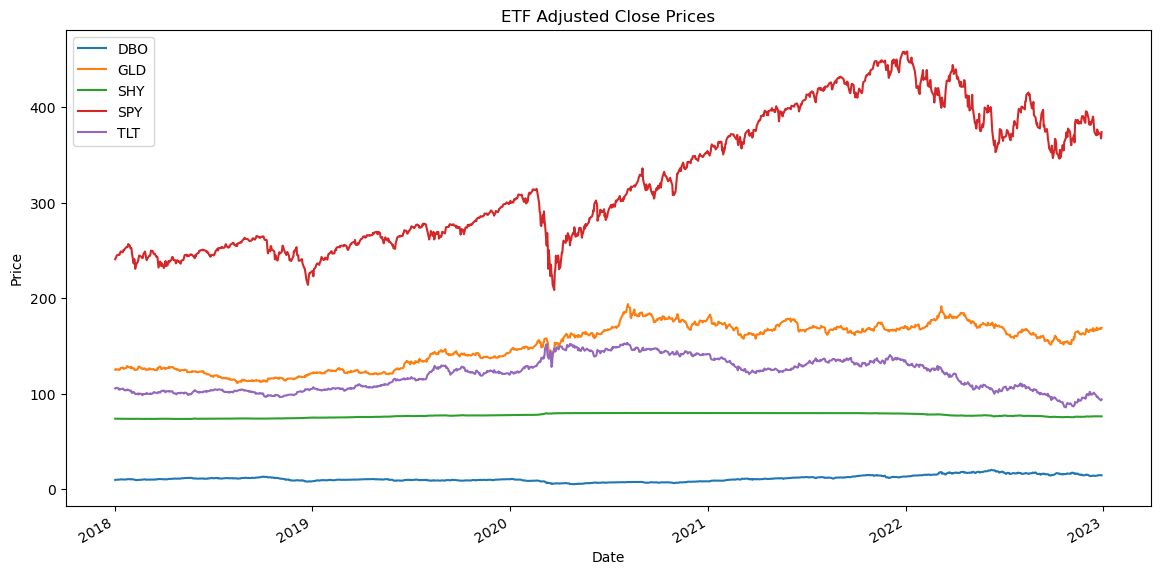

In [3]:
# Plot ETF prices
df.plot(figsize=(14, 7), title='ETF Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


### **3. Stationarity Test**

Log returns are computed to ensure stationarity, a critical requirement for time-series analysis. An Augmented Dickey-Fuller (ADF) test is performed for each ETF to statistically verify stationarity.


In [ ]:
# Calculate daily log returns
log_returns = np.log(df / df.shift(1)).dropna()

# Save log returns
log_returns.to_csv("./data/processed/log_returns.csv", index=True)

# Perform stationarity tests (ADF Test)
print("ADF Test Results:")
for etf in etfs:
    result = adfuller(log_returns[etf])
    print(f'{etf}: ADF Statistic = {result[0]}, p-value = {result[1]}')

# Save results of ADF test to a file
adf_results = {etf: {'ADF Statistic': result[0], 'p-value': result[1]} for etf in etfs}
with open("./data/processed/adf_test_results.pkl", "wb") as file:
    pickle.dump(adf_results, file)

ADF Test Results:
SPY: ADF Statistic = -10.84849288105641, p-value = 1.55031977310018e-19
TLT: ADF Statistic = -10.603385027958828, p-value = 6.089476133719365e-19
SHY: ADF Statistic = -6.670509653665776, p-value = 4.600598234281105e-09
GLD: ADF Statistic = -15.41761171640279, p-value = 3.0645287583320246e-28
DBO: ADF Statistic = -36.908578332595084, p-value = 0.0


### **4. Seasonal Decomposition**

The time series for each ETF is decomposed into its components: observed, trend, seasonal, and residual. This analysis provides insights into the underlying patterns and randomness in the data.


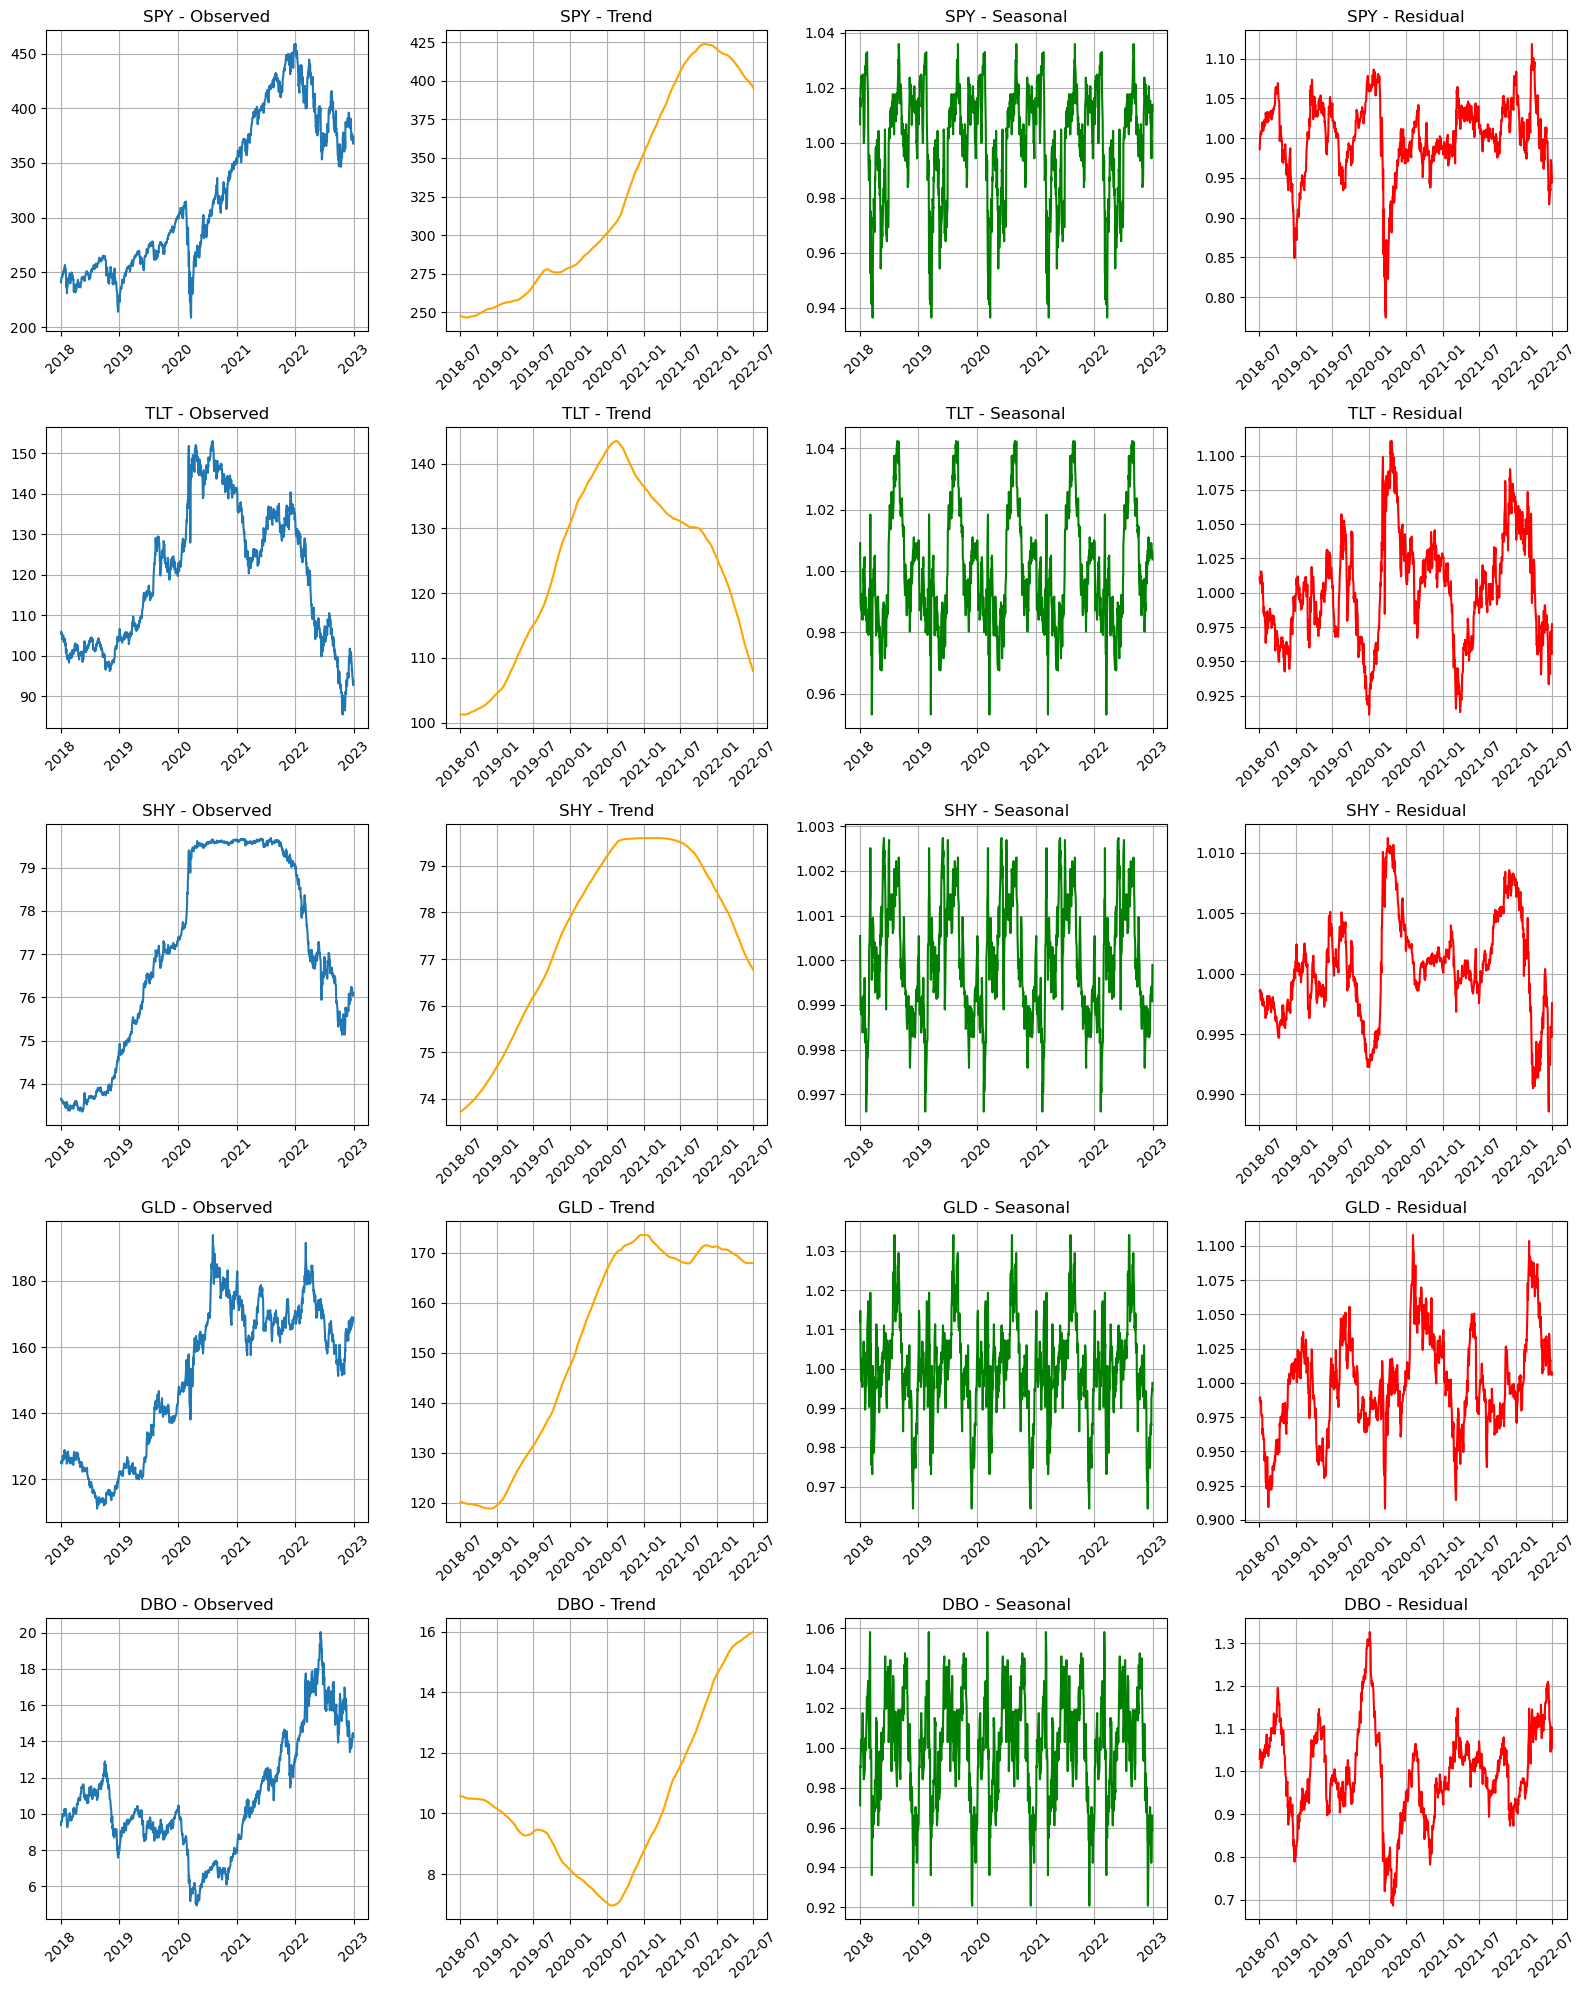

In [5]:
# Seasonal decomposition with subplots
fig, axes = plt.subplots(nrows=len(etfs), ncols=4, figsize=(16, len(etfs) * 4))

# Iterate over ETFs and create subplots
for i, etf in enumerate(etfs):
    decomposition = seasonal_decompose(df[etf], model='multiplicative', period=252)
    
    # Plot observed
    axes[i, 0].plot(decomposition.observed, label='Observed')
    axes[i, 0].set_title(f'{etf} - Observed')
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid()

    # Plot trend
    axes[i, 1].plot(decomposition.trend, label='Trend', color='orange')
    axes[i, 1].set_title(f'{etf} - Trend')
    axes[i, 1].tick_params(axis='x', rotation=45)
    axes[i, 1].grid()

    # Plot seasonal
    axes[i, 2].plot(decomposition.seasonal, label='Seasonal', color='green')
    axes[i, 2].set_title(f'{etf} - Seasonal')
    axes[i, 2].tick_params(axis='x', rotation=45)
    axes[i, 2].grid()

    # Plot residual
    axes[i, 3].plot(decomposition.resid, label='Residual', color='red')
    axes[i, 3].set_title(f'{etf} - Residual')
    axes[i, 3].tick_params(axis='x', rotation=45)
    axes[i, 3].grid()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


### **5. Summary Statistics and Correlation**

Summary statistics such as mean, standard deviation, and percentiles are computed for the log returns. A pairplot is generated to examine pairwise relationships, and a heatmap shows the correlation matrix to understand interdependencies among the ETFs.


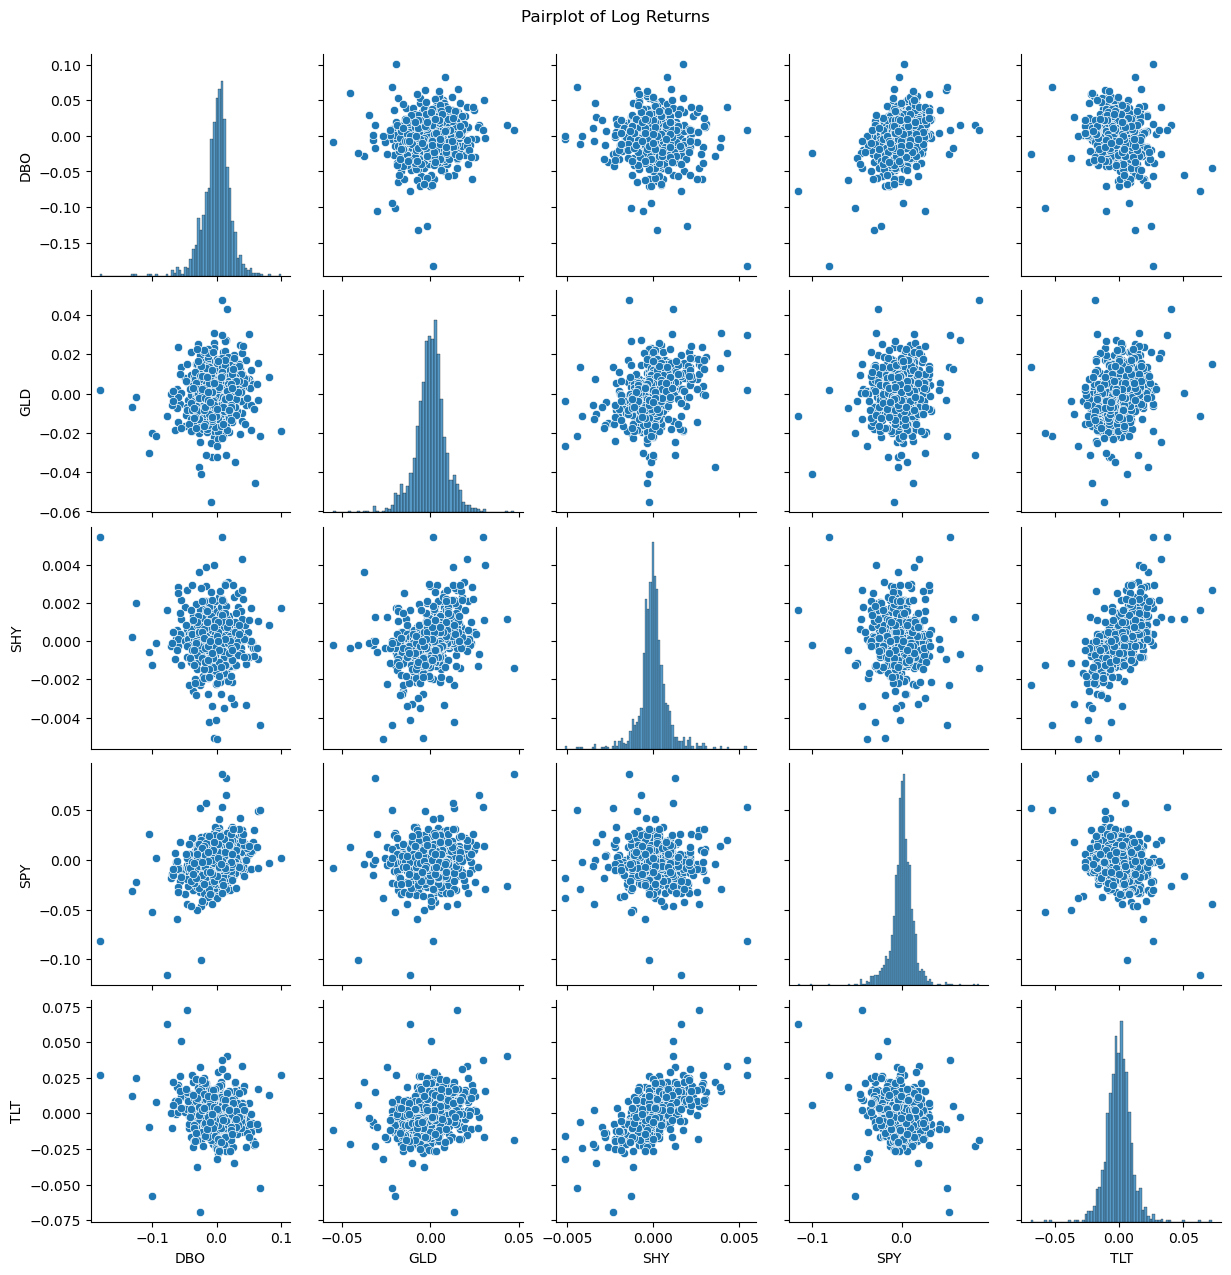

In [6]:
# Pair plot for log returns
sns.pairplot(log_returns)
plt.suptitle("Pairplot of Log Returns", y=1.02)
plt.show()


Summary Statistics:
                DBO          GLD          SHY          SPY          TLT
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000
mean      0.000332     0.000238     0.000026     0.000351    -0.000093
std       0.021855     0.009057     0.000882     0.013638     0.010162
min      -0.182065    -0.055190    -0.005101    -0.115887    -0.069011
25%      -0.009655    -0.004336    -0.000348    -0.005144    -0.005798
50%       0.002434     0.000518     0.000000     0.000772     0.000072
75%       0.012628     0.005080     0.000354     0.007088     0.005641
max       0.100955     0.047390     0.005438     0.086731     0.072503


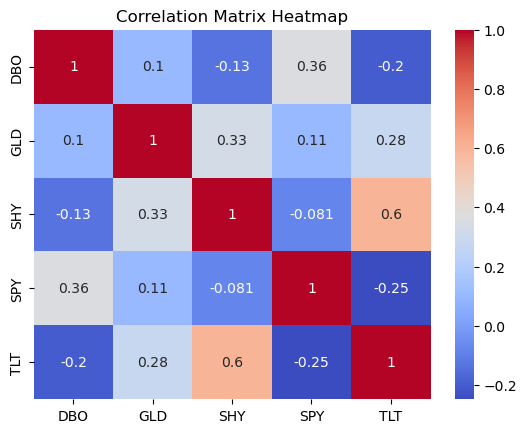

In [7]:
# Summary statistics and correlation
print("Summary Statistics:\n", log_returns.describe())
correlation = log_returns.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


## **Step 2: LSTM Model Development for Single-Output Models**

### **1. Data Preparation**

The log return data is split into training, validation, and test sets. A sliding window of 25 days is used to create input-output pairs, where the model predicts the average return over the next 25 days.


In [8]:
# Define time step
time_step = 25

# Split data into training, validation, and test sets
train_size = int(len(log_returns) * 0.7)
val_size = int(len(log_returns) * 0.15)
test_size = len(log_returns) - train_size - val_size

train_data = log_returns.iloc[:train_size]
val_data = log_returns.iloc[train_size:train_size+val_size]
test_data = log_returns.iloc[train_size+val_size:]


In [ ]:
# Save split data
train_data.to_csv("./data/processed/train_data.csv", index=True)
val_data.to_csv("./data/processed/val_data.csv", index=True)
test_data.to_csv("./data/processed/test_data.csv", index=True)

In [10]:
# Function to create datasets
def create_dataset(series, time_step, ahead=25):
    X, y = [], []
    for i in range(len(series) - time_step - ahead + 1):
        X.append(series[i:i + time_step])
        y.append(series[i + time_step:i + time_step + ahead].mean())
    return np.array(X), np.array(y)

data = {}
for etf in etfs:
    # Scale data
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_data[[etf]])
    scaled_val = scaler.transform(val_data[[etf]])
    scaled_test = scaler.transform(test_data[[etf]])
    
    # Create datasets
    X_train, y_train = create_dataset(scaled_train, time_step)
    X_val, y_val = create_dataset(np.vstack((scaled_train[-time_step:], scaled_val)), time_step)
    X_test, y_test = create_dataset(np.vstack((scaled_val[-time_step:], scaled_test)), time_step)
    
    # Reshape inputs for LSTM [samples, time_steps, features]
    X_train = X_train.reshape(-1, time_step, 1)
    X_val = X_val.reshape(-1, time_step, 1)
    X_test = X_test.reshape(-1, time_step, 1)
    
    # Store data
    data[etf] = {
        'scaler': scaler,
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test
    }


### **2. Model Building and Training**

An LSTM architecture is implemented for each ETF. The model includes two LSTM layers, dropout layers for regularization, and a dense output layer. Each model is trained separately on its corresponding ETF data, and training-validation loss curves are plotted.


2024-12-04 16:17:51.839703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training model for SPY...
Epoch 1/20


26/26 [==============================] - 3s 34ms/step - loss: 0.0503 - val_loss: 0.0030
Epoch 2/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 2.9507e-04
Epoch 3/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 1.3636e-04
Epoch 4/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 1.2332e-04
Epoch 5/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 1.4998e-04
Epoch 6/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 1.8451e-04
Epoch 7/20
26/26 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 1.3170e-04
Epoch 8/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 1.1860e-04
Epoch 9/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 1.4401e-04
Epoch 10/20
26/26 [==============================] - 0s 14ms/step - loss: 0.0026 - val_l

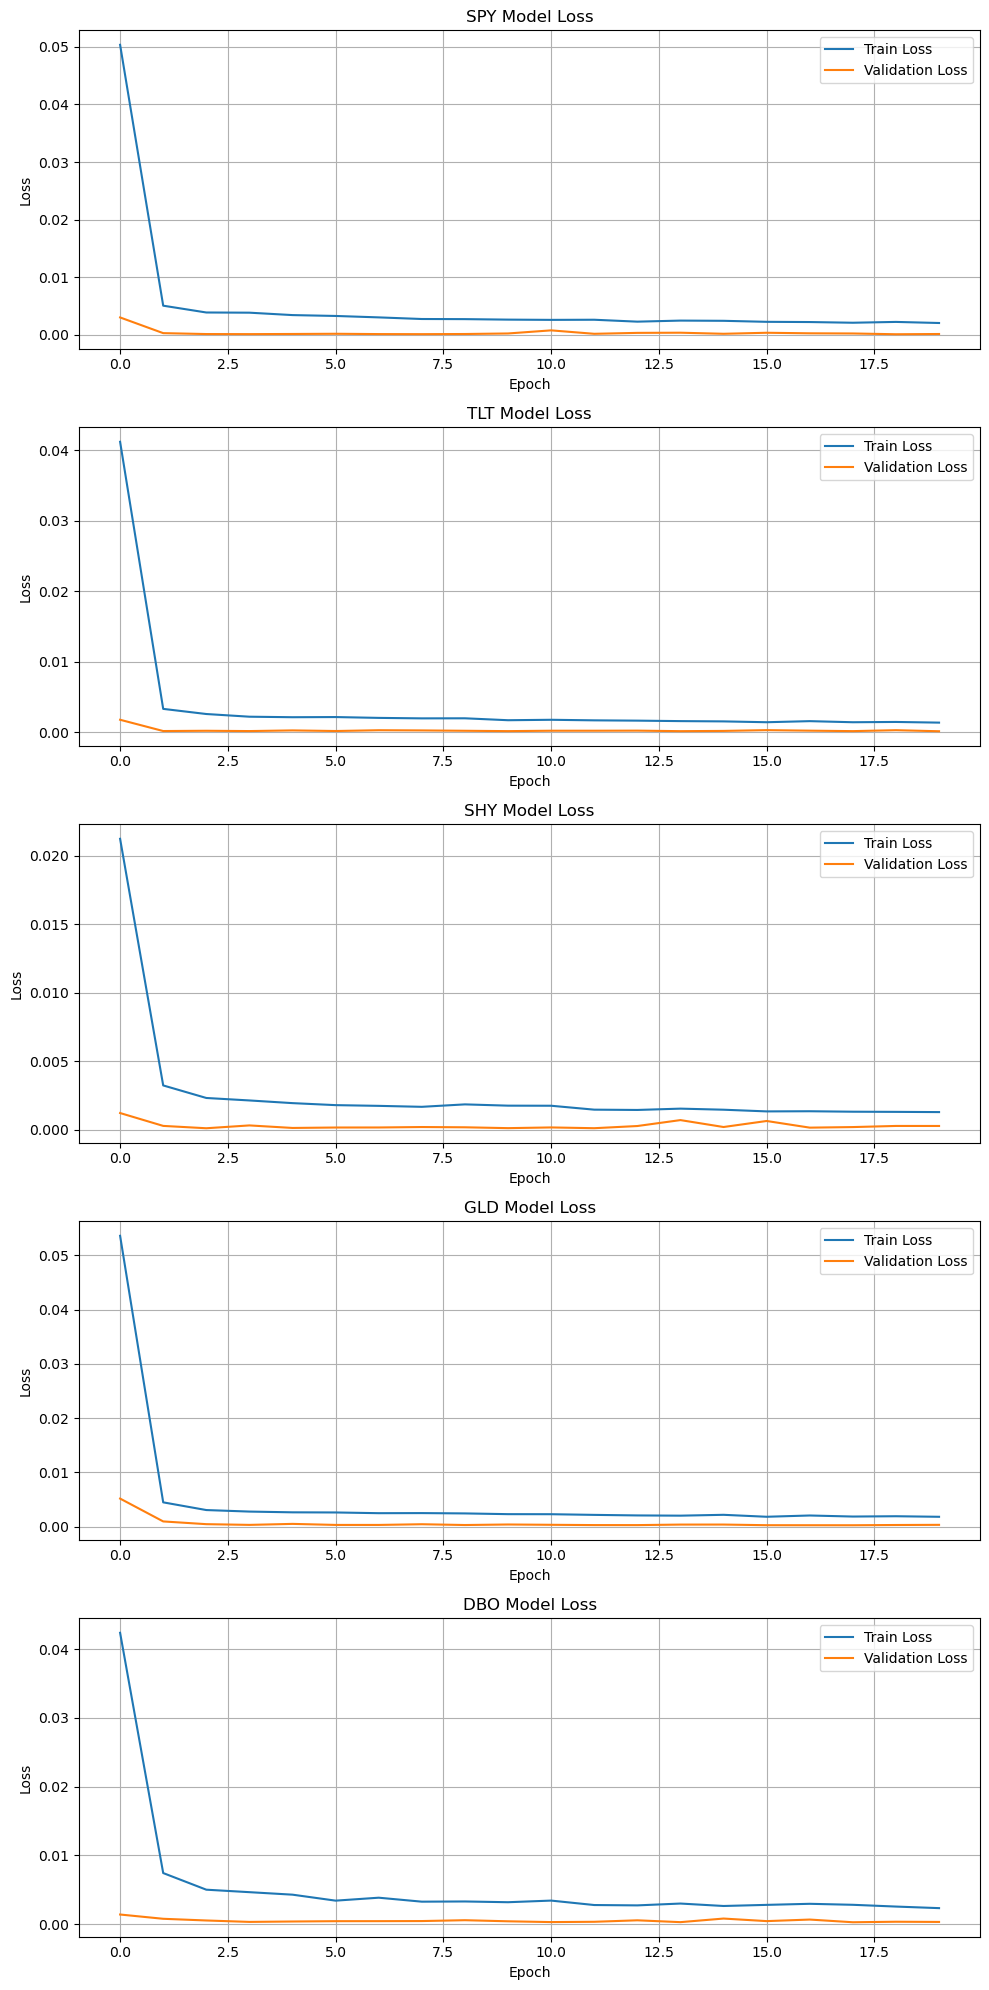

In [ ]:
models = {}
histories = {}

# Initialize sub-plot for loss curves
fig, axes = plt.subplots(nrows=len(etfs), ncols=1, figsize=(10, len(etfs) * 4))
axes = axes.flatten()  # Ensure axes is iterable

for i, etf in enumerate(etfs):
    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
        Dropout(0.2),  # Prevent overfitting
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Train model
    print(f"Training model for {etf}...")
    history = model.fit(
        data[etf]['X_train'], data[etf]['y_train'],
        epochs=20,
        batch_size=32,
        validation_data=(data[etf]['X_val'], data[etf]['y_val']),
        verbose=1
    )
    
    # Save model
    model.save(f"./data/models/{etf}_lstm_model.h5")
    
    # Save training history
    with open(f"./data/models/{etf}_training_history.pkl", "wb") as file:
        pickle.dump(history.history, file)

    # Store model and training history
    models[etf] = model
    histories[etf] = history
    
    # Plot loss curves
    axes[i].plot(history.history['loss'], label='Train Loss')
    axes[i].plot(history.history['val_loss'], label='Validation Loss')
    axes[i].set_title(f'{etf} Model Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].legend()
    axes[i].grid()

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [ ]:
# Save all histories as a single file (optional)
with open("./data/models/all_training_histories.pkl", "wb") as file:
    pickle.dump(histories, file)


INFO:tensorflow:Assets written to: ram://5faf89be-59e9-41f4-b657-e3b98e12a2b8/assets


INFO:tensorflow:Assets written to: ram://5faf89be-59e9-41f4-b657-e3b98e12a2b8/assets


INFO:tensorflow:Assets written to: ram://42defa29-797d-4e14-8639-5b523d64c630/assets


INFO:tensorflow:Assets written to: ram://42defa29-797d-4e14-8639-5b523d64c630/assets


INFO:tensorflow:Assets written to: ram://d343a9dc-2691-4abc-95ba-fe13563361f8/assets


INFO:tensorflow:Assets written to: ram://d343a9dc-2691-4abc-95ba-fe13563361f8/assets


INFO:tensorflow:Assets written to: ram://ab258dc4-c07a-4a8b-b732-6873d64f2440/assets


INFO:tensorflow:Assets written to: ram://ab258dc4-c07a-4a8b-b732-6873d64f2440/assets


INFO:tensorflow:Assets written to: ram://332e85f2-5e3f-4362-98c0-f05c0b6fbfe3/assets


INFO:tensorflow:Assets written to: ram://332e85f2-5e3f-4362-98c0-f05c0b6fbfe3/assets


### **3. Model Evaluation**

The predictive performance of each model is evaluated on the test set using metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). Actual vs. predicted returns are plotted for each ETF to visualize model accuracy.


6/6 [==============================] - 0s 4ms/step
SPY - MSE: 0.000016, MAE: 0.003382, MAPE: 3.294342
6/6 [==============================] - 0s 4ms/step
TLT - MSE: 0.000009, MAE: 0.002330, MAPE: 2.641677
6/6 [==============================] - 0s 4ms/step
SHY - MSE: 0.000000, MAE: 0.000283, MAPE: 3.706472
6/6 [==============================] - 0s 4ms/step
GLD - MSE: 0.000005, MAE: 0.001894, MAPE: 7.392660
6/6 [==============================] - 0s 4ms/step
DBO - MSE: 0.000024, MAE: 0.003962, MAPE: 4.980673


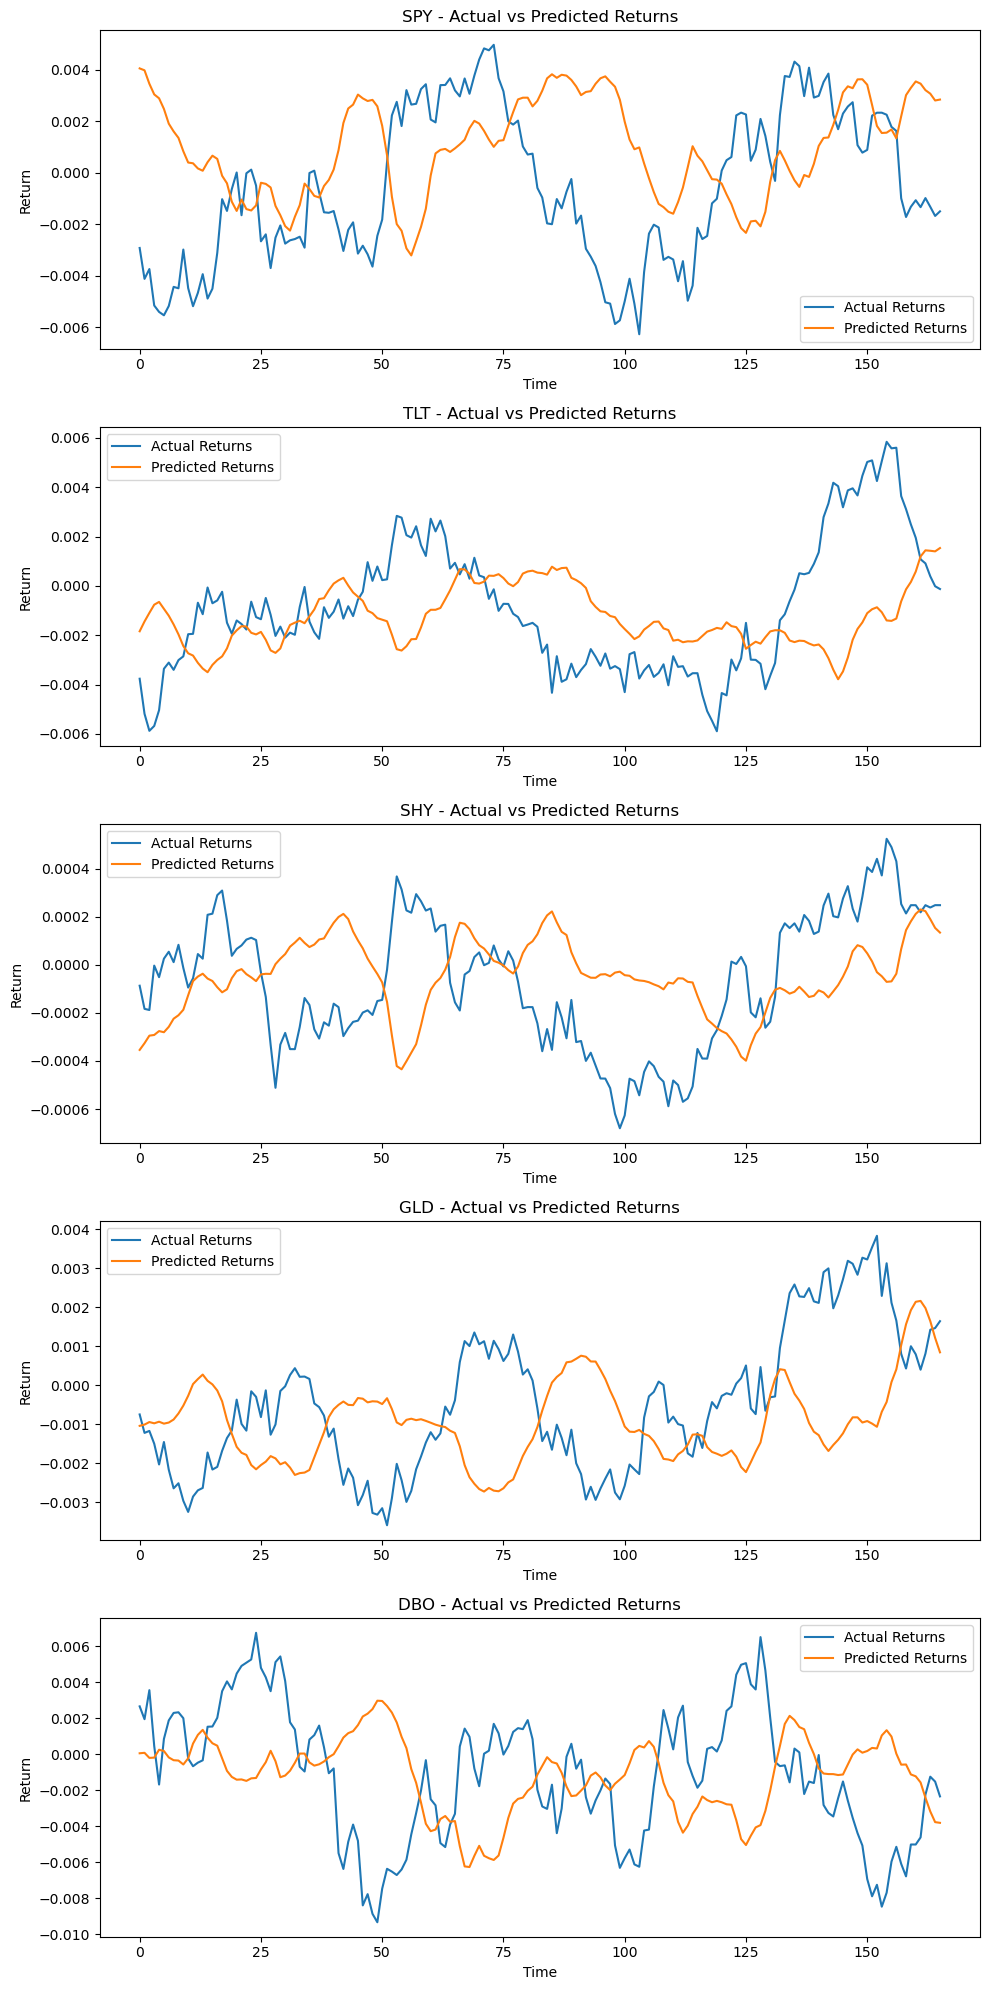

In [13]:
performance = {}

# Initialize sub-plot for predictions
fig, axes = plt.subplots(nrows=len(etfs), ncols=1, figsize=(10, len(etfs) * 4))
axes = axes.flatten()  # Ensure axes is iterable

for i, etf in enumerate(etfs):
    # Predictions
    y_pred = models[etf].predict(data[etf]['X_test'])
    
    # Inverse scaling
    scaler = data[etf]['scaler']
    y_test_inv = scaler.inverse_transform(data[etf]['y_test'].reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    # Performance metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
    
    performance[etf] = {'MSE': mse, 'MAE': mae, 'MAPE': mape}
    
    # Plot predictions in sub-plot
    axes[i].plot(y_test_inv, label='Actual Returns')
    axes[i].plot(y_pred_inv, label='Predicted Returns')
    axes[i].set_title(f'{etf} - Actual vs Predicted Returns')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Return')
    axes[i].legend()
    
    print(f"{etf} - MSE: {mse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.6f}")

# Adjust layout
plt.tight_layout()
plt.show()


### **4. Trading Strategy Development and Backtesting**

A simple trading strategy is designed based on model predictions:
1. Long the top 2 ETFs with the highest predicted returns.
2. Short the bottom 2 ETFs with the lowest predicted returns.

The cumulative returns of this strategy are compared against a buy-and-hold strategy, and performance metrics such as Sharpe Ratio and Maximum Drawdown are calculated.


In [14]:
# Sharpe Ratio and Maximum Drawdown Function
def calculate_metrics(cum_returns):
    """
    Calculate performance metrics for a trading strategy.
    Args:
        cum_returns (pd.Series): Cumulative returns of the strategy.
    Returns:
        dict: A dictionary containing Sharpe Ratio and Maximum Drawdown.
    """
    daily_returns = cum_returns.diff().fillna(0)  # Calculate daily returns
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized Sharpe Ratio
    max_drawdown = np.min(cum_returns - cum_returns.cummax())  # Maximum Drawdown
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown
    }

# Trading Strategy Implementation
def trading_strategy(predictions, test_data, top_k=2):
    """
    Implements a simple trading strategy:
    - Long the `top_k` ETFs with the highest predicted returns.
    - Short the `top_k` ETFs with the lowest predicted returns.
    """
    strategy_returns = []
    for i in range(len(predictions

[etfs[0]])):  # Iterate through each time step
        pred_returns = {etf: predictions[etf][i] for etf in etfs}
        
        # Sort ETFs by predicted returns
        sorted_preds = sorted(pred_returns.items(), key=lambda x: x[1], reverse=True)
        long_positions = [sorted_preds[j][0] for j in range(top_k)]
        short_positions = [sorted_preds[-j - 1][0] for j in range(top_k)]
        
        # Calculate strategy return for this step
        step_return = 0
        for etf in long_positions:
            step_return += test_data[etf].iloc[i]
        for etf in short_positions:
            step_return -= test_data[etf].iloc[i]
        
        strategy_returns.append(step_return)
    
    # Normalize starting point to 0 for consistency
    strategy_cum_returns = np.cumsum(strategy_returns) - np.cumsum(strategy_returns)[0]
    return pd.Series(strategy_cum_returns, index=test_data.index[:len(strategy_cum_returns)])  # Tie to index


In [15]:
# Collect predictions for all ETFs
predictions = {}
for etf in etfs:
    y_pred = models[etf].predict(data[etf]['X_test'])
    scaler = data[etf]['scaler']
    predictions[etf] = scaler.inverse_transform(y_pred).flatten()

# Strategy Cumulative Returns
strategy_cum_returns = trading_strategy(predictions, test_data)

# Strategy Metrics
strategy_metrics = calculate_metrics(strategy_cum_returns)

# Buy-and-Hold Strategy
equal_weights = np.full(len(etfs), 1 / len(etfs))
buy_and_hold_returns = test_data[etfs].dot(equal_weights)
buy_and_hold_cum_returns = np.cumsum(buy_and_hold_returns) - np.cumsum(buy_and_hold_returns)[0]
buy_and_hold_cum_returns = pd.Series(buy_and_hold_cum_returns, index=test_data.index[:len(buy_and_hold_cum_returns)])

# Buy-and-Hold Metrics
buy_and_hold_metrics = calculate_metrics(buy_and_hold_cum_returns)


6/6 [==============================] - 0s 4ms/step


In [16]:
# Print Metrics
print("Strategy Metrics:")
print(f"Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.2f}")
print(f"Maximum Drawdown: {strategy_metrics['Maximum Drawdown']:.2%}")

print("\nBuy-and-Hold Metrics:")
print(f"Sharpe Ratio: {buy_and_hold_metrics['Sharpe Ratio']:.2f}")
print(f"Maximum Drawdown: {buy_and_hold_metrics['Maximum Drawdown']:.2%}")


Strategy Metrics:
Sharpe Ratio: -0.72
Maximum Drawdown: -41.21%

Buy-and-Hold Metrics:
Sharpe Ratio: -1.35
Maximum Drawdown: -17.24%


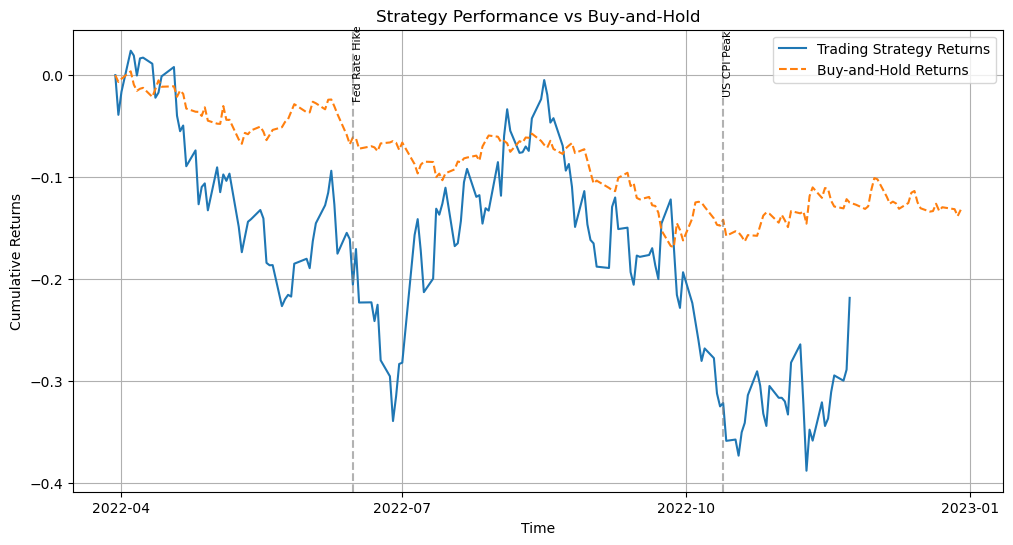

In [17]:
# Highlight Significant Market Events
significant_events = {
    "2022-06-15": "Fed Rate Hike",
    "2022-10-13": "US CPI Peak",
    "2022-12-13": "Fed Signals Slower Hikes"
}

# Convert significant event dates to datetime objects
significant_events = {pd.Timestamp(date): event for date, event in significant_events.items()}

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(strategy_cum_returns, label="Trading Strategy Returns")
plt.plot(buy_and_hold_cum_returns, label="Buy-and-Hold Returns", linestyle='dashed')

# Annotate significant events
for date, event in significant_events.items():
    if date in strategy_cum_returns.index:
        plt.axvline(x=date, color='gray', linestyle='--', alpha=0.6)
        plt.text(date, strategy_cum_returns.max() * 0.5, event, rotation=90, verticalalignment='center', fontsize=8)

# Customizing Plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))  # Quarterly ticks: Jan, Apr, Jul, Oct
plt.title("Strategy Performance vs Buy-and-Hold")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


## **Step 3: Multi-Output LSTM Model Implementation and Performance Analysis**

### **1. Data Preparation**

All ETFs are combined into a single dataset. Input-output pairs are created with a similar sliding window approach, but the model now predicts the next 25-day returns for all ETFs simultaneously.


In [ ]:
# Data Preparation for Multi-Output Model
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[etfs])
scaled_val = scaler.transform(val_data[etfs])
scaled_test = scaler.transform(test_data[etfs])

# Save the multi-output scaler
with open("./data/models/multi_output_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

# Create datasets for multi-output model
def create_multi_output_dataset(series, time_step):
    X, y = [], []
    for i in range(len(series) - time_step):
        X.append(series[i:i + time_step])
        y.append(series[i + time_step])
    return np.array(X), np.array(y)

X_train, y_train = create_multi_output_dataset(scaled_train, time_step)
X_val, y_val = create_multi_output_dataset(np.vstack((scaled_train[-time_step:], scaled_val)), time_step)
X_test, y_test = create_multi_output_dataset(np.vstack((scaled_val[-time_step:], scaled_test)), time_step)


### **2. Model Building and Training**

A multi-output LSTM model is built to capture interdependencies among ETFs. The architecture includes two LSTM layers, dropout layers, and a dense output layer with five outputs (one for each ETF). Training-validation loss curves are plotted.


In [ ]:
# Build and train multi-output model
multi_output_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, len(etfs))),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(len(etfs))
])
multi_output_model.compile(optimizer='adam', loss='mse')

multi_output_history = multi_output_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

# Save multi-output model
multi_output_model.save("./data/models/multi_output_lstm_model.h5")

# Save multi-output training history
with open("./data/models/multi_output_training_history.pkl", "wb") as file:
    pickle.dump(multi_output_history.history, file)


Epoch 1/20


27/27 [==============================] - 3s 42ms/step - loss: 0.0463 - val_loss: 0.0084
Epoch 2/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0120 - val_loss: 0.0063
Epoch 3/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0106 - val_loss: 0.0068
Epoch 4/20
27/27 [==============================] - 1s 27ms/step - loss: 0.0101 - val_loss: 0.0070
Epoch 5/20
27/27 [==============================] - 1s 31ms/step - loss: 0.0095 - val_loss: 0.0067
Epoch 6/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0092 - val_loss: 0.0065
Epoch 7/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0093 - val_loss: 0.0063
Epoch 8/20
27/27 [==============================] - 1s 27ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 9/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 10/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 11/20
27/27 [=

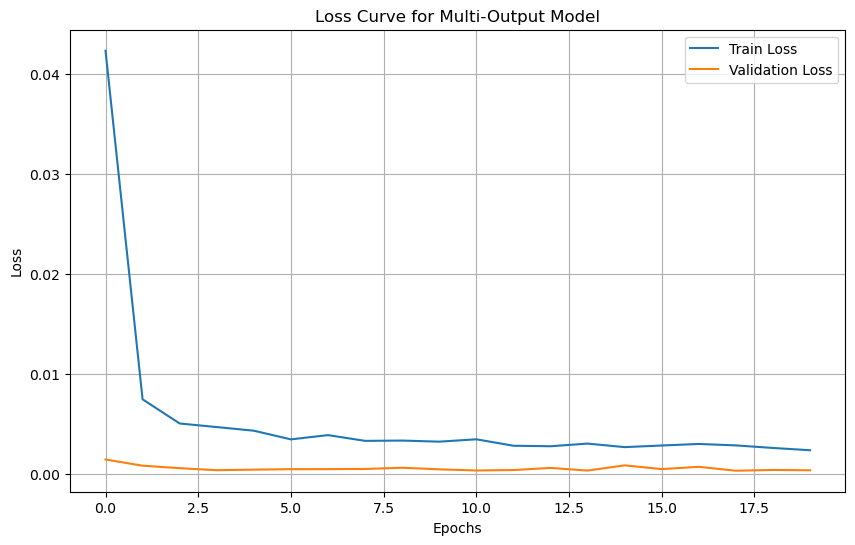

In [20]:
# Plot Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss Curve for Multi-Output Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### **3. Model Evaluation**

The multi-output model's predictions are evaluated using MSE and MAE metrics. Actual vs. predicted returns are plotted for each ETF to assess performance.


6/6 [==============================] - 0s 8ms/step
Multi-Output Model - MSE: 0.000229, MAE: 0.010416


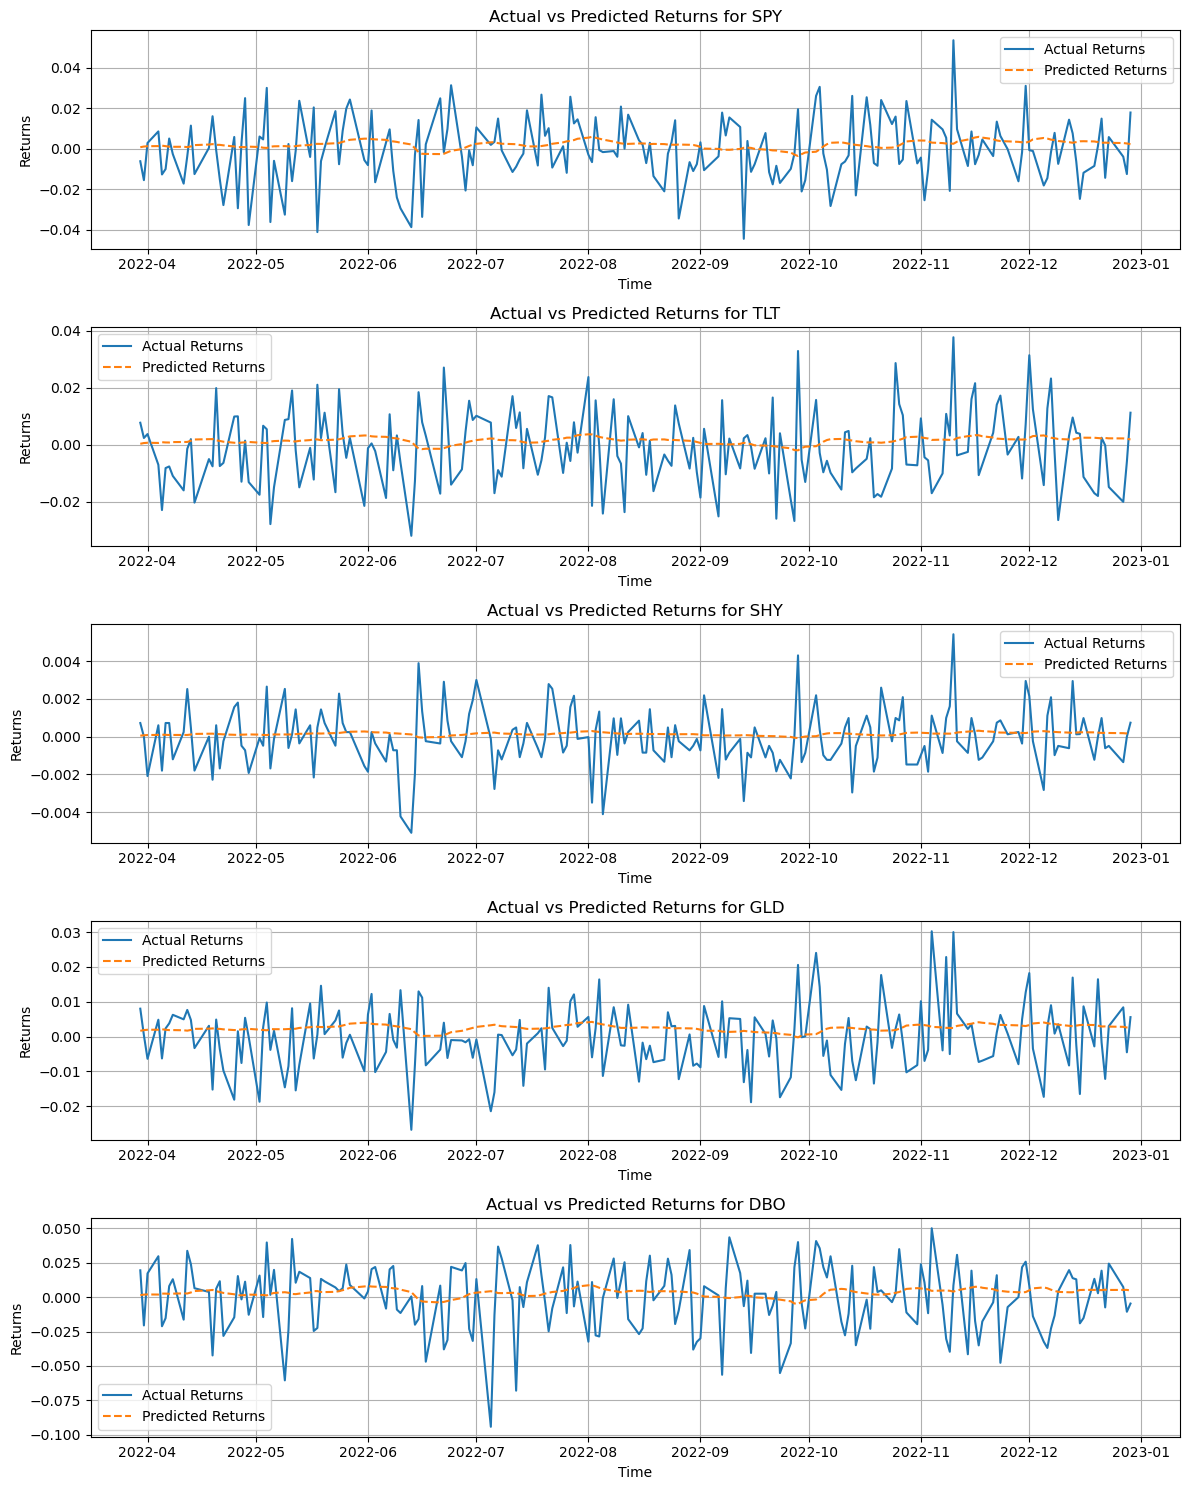

In [21]:
# Predictions and Inverse Scaling
y_pred = multi_output_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, len(etfs)))
y_pred_inv = scaler.inverse_transform(y_pred)

# Align Predictions and Test Data with Index
y_pred_inv = pd.DataFrame(y_pred_inv, index=test_data.index[:len(y_pred_inv)], columns=etfs)
y_test_inv = pd.DataFrame(y_test_inv, index=test_data.index[:len(y_test_inv)], columns=etfs)

# Calculate MSE and MAE
mse = mean_squared_error(y_test_inv.values.flatten(), y_pred_inv.values.flatten())
mae = mean_absolute_error(y_test_inv.values.flatten(), y_pred_inv.values.flatten())
print(f"Multi-Output Model - MSE: {mse:.6f}, MAE: {mae:.6f}")

# Plot Actual vs Predicted Returns (in Subplots)
fig, axes = plt.subplots(nrows=len(etfs), ncols=1, figsize=(12, len(etfs) * 3))
axes = axes.flatten()
for i, etf in enumerate(etfs):
    axes[i].plot(y_test_inv[etf], label="Actual Returns")
    axes[i].plot(y_pred_inv[etf], label="Predicted Returns", linestyle='dashed')
    axes[i].set_title(f"Actual vs Predicted Returns for {etf}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Returns")
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()


### **4. Trading Strategy Development and Backtesting**

A trading strategy is developed based on the multi-output model's predictions, similar to the single-output strategy. Its cumulative returns are compared against the buy-and-hold strategy, and significant market events are annotated on the performance chart.


In [22]:
# Multi-Output Strategy Development
def multi_output_trading_strategy(predictions, test_data, top_k=2):
    strategy_returns = []
    for i in range(len(predictions)):
        pred_returns = predictions.iloc[i]
        
        # Long and Short Positions
        long_positions = pred_returns.nlargest(top_k).index
        short_positions = pred_returns.nsmallest(top_k).index
        
        # Calculate Strategy Return
        step_return = test_data.iloc[i][long_positions].sum() - test_data.iloc[i][short_positions].sum()
        strategy_returns.append(step_return)
    
    # Normalize Starting Point
    strategy_cum_returns = np.cumsum(strategy_returns) - np.cumsum(strategy_returns)[0]
    return pd.Series(strategy_cum_returns, index=test_data.index[:len(strategy_cum_returns)])


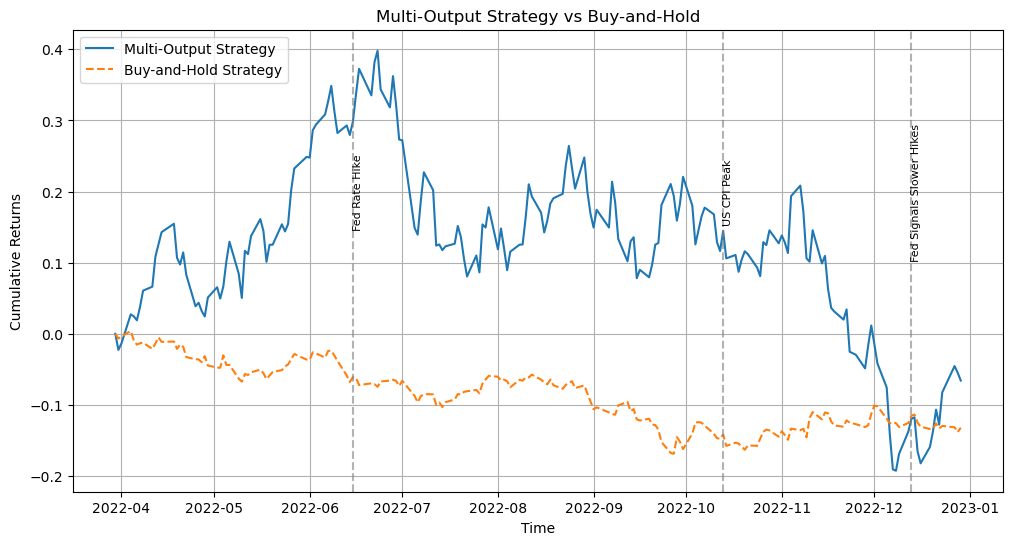

In [23]:
# Generate Cumulative Returns for Multi-Output Strategy
multi_output_strategy_cum_returns = multi_output_trading_strategy(y_pred_inv, test_data)

# Buy-and-Hold Strategy
equal_weights = np.full(len(etfs), 1 / len(etfs))
buy_and_hold_returns = test_data[etfs].dot(equal_weights)
buy_and_hold_cum_returns = np.cumsum(buy_and_hold_returns) - np.cumsum(buy_and_hold_returns)[0]
buy_and_hold_cum_returns = pd.Series(buy_and_hold_cum_returns, index=test_data.index[:len(buy_and_hold_cum_returns)])

# Ensure Alignment of Strategy Returns
multi_output_strategy_cum_returns = multi_output_strategy_cum_returns.iloc[:len(buy_and_hold_cum_returns)]

# Highlight Significant Market Events
significant_events = {
    "2022-06-15": "Fed Rate Hike",
    "2022-10-13": "US CPI Peak",
    "2022-12-13": "Fed Signals Slower Hikes"
}
significant_events = {pd.Timestamp(date): event for date, event in significant_events.items()}

# Plot Multi-Output Strategy vs Buy-and-Hold
plt.figure(figsize=(12, 6))
plt.plot(multi_output_strategy_cum_returns, label="Multi-Output Strategy")
plt.plot(buy_and_hold_cum_returns, label="Buy-and-Hold Strategy", linestyle='dashed')

# Annotate significant events
for date, event in significant_events.items():
    if date in multi_output_strategy_cum_returns.index:
        plt.axvline(x=date, color='gray', linestyle='--', alpha=0.6)
        plt.text(date, multi_output_strategy_cum_returns.max() * 0.5, event, rotation=90, verticalalignment='center', fontsize=8)

# Formatting and Titles
plt.title("Multi-Output Strategy vs Buy-and-Hold")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


#### **Results and Insights**

- **Performance Comparison**: Single-output models exhibit better individual ETF prediction accuracy, while the multi-output model captures cross-asset relationships.
- **Trading Strategy**: The multi-output strategy achieves a higher Sharpe Ratio but suffers from higher drawdowns compared to the single-output strategy.
- **Significant Events**: The models' performance is influenced by market events such as rate hikes and inflation peaks, emphasizing the need for macroeconomic context in trading strategies.


## **References**

1. Ćirić, Milica, et al. "Single and Multiple Separate LSTM Neural Networks for Multiple Output Feature Purchase Prediction." *Electronics*, vol. 12, no. 12, 2023, p. 2616, doi:10.3390/electronics12122616.

2. Van Houdt, Greg, et al. "A Review on the Long Short-Term Memory Model." *Artificial Intelligence Review*, vol. 53, no. 8, 2020, pp. 5929-5955, doi:10.1007/s10462-020-09838-1.

3. Ma, Meng, et al. "Predicting Machine's Performance Record Using the Stacked Long Short‐Term Memory (LSTM) Neural Networks." *Journal of Applied Clinical Medical Physics*, vol. 23, no. 3, 2022, p. e13558, doi:10.1002/acm2.13558.

4. Yan, Xiaoyong, et al. "Research on Financial Assets Transaction Prediction Model Based on LSTM Neural Network." *Neural Computing and Applications*, vol. 33, no. 1, 2021, pp. 257-270, doi:10.1007/s00521-020-04992-7.

5. Vezeris, Dimitrios T., et al. "Optimization of Backtesting Techniques in Automated High Frequency Trading Systems Using the d-Backtest PS Method." *Computational Economics*, vol. 56, 2020, pp. 975-1054, doi:10.1007/s10614-019-09956-1.

6. Khemka, Gaurav, et al. "A Buy-Hold-Sell Pension Saving Strategy." *SSRN*, 2024, doi:10.2139/ssrn.4519652.

7. Silvestre-Ponce, Carlos, et al. "Modeling and Predicting the Yield Curve of the Chilean Bond Market Through Multi-Output LSTM." *SSRN*, 2023, doi:10.2139/ssrn.4643746.